<h2 align="center">Summary Report for</h2>
<h1 align="center">Multi-Physics Multi-Scale Computational Modeling, LLC</h1>
<h2 align="center">Bill Spotz</h2>
<h2 align="center">Sandia National Laboratories</h2>
<h2 align="center">December 19, 2018</h2>

**Statement of Work:**  SNL will provide, as time and budget allows, consultation developing a code that takes as input a description of a partial differential equation (e.g. in LaTeX syntax) and that generates as output a C++ class that is a viable Albany evaluator that computes the finite element residual of the provided equation. SNL will also provide consultation to demonstrate this capability to solve a simple model problem. A summary report will be written.

# Summary

A Python module, REGen, was developed that can take a symbolic description of a partial differential equation (PDE) and produce a symbolic representation of its finite element approximation.  This capability is enabled by a series of Python functions that perform the following symbolic mathematical manipulations: convert a PDE to its weak form, including the application of integration by parts; apply a Galerkin approximation; apply certain simplifications that arise from using cardinal basis functions; substitute quadrature formulae for integrals; and making some functional substitutions to enable code generation.  The Statement of Work (SOW) mentions the possibility of accepting PDEs in LaTeX syntax; this possibility was studied, but not extensively. Syntax supported by the SymPy module used in this project proved to be both easy to learn and work with.  The SOW also mentions generating code suitable for use as a `ModelEvaluator` within Albany.  The built-in SymPy code generators proved too fragile to achieve this goal in the allotted time.  The solution to this might be to develop specialized external code generators that are designed to handle the summations, basis functions, derivatives of basis functions, and other peculiarities of finite element approximations.  Experience gained in this project indicates that such code generators should be achievable with low to moderate effort.

# Introduction

To complete the Statement of Work (SOW), a set of tools was chosen that are appropriate to the task: The Jupyter Notebook running Python 3, using SymPy:

   *  **Jupyter Notebook** The goal is for users to start with a representation of a partial differential equation (PDE), and generate code that is a finite element representation of that PDE.  As such, we want a tool that provides an interface to code but that also renders beautiful mathematics.  The Jupyter Notebook fills these requirements and much more.  Note that this summary report is generated using Jupyter Notebook.

   *  **Python 3** Jupyter Notebooks support many languages, but historically Python was the first.  Python syntax is clean and easy for users to pick up, the collection of built-in and third-party libraries is extensive, and the scientific Python community is sizeable, broad and vibrant.  Python 2 is still in extensive use, but all relevant third-party libraries have long been ported to Python 3, and there is no legacy justification for using Python 2.

   *  **SymPy** *Sym*bolic *Py*thon is a third-party symbolic manipulation module for Python that provides the capability of manipulating PDEs in the manner prescribed by the SOW.  Specifically, it supports mathematical manipulation of derivatives, integrals, summations and a host of other mathematical objects.  For set of simple expressions, it can convert its representation of expressions into code, valid for many different programming  languages.  Unfortunately, these existing code generators do not appear up to the task for the finite element approximations derived here.

**A note about this Summary Report:** This report was developed within a Jupyter Notebook, which means that the code presented in the report is "live" when viewed using Jupyter Notebook.  Cell blocks preceeded by `In [#]: ` where `#` is a number, are actual code, and cell blocks preceeded by `Out[#]: ` are the actual output produced by the code block with the same number.  Changing the input code will change the resulting output.  Notably, SymPy mathematical objects can be rendered as professionally typeset mathematics within a Jupyter Notebook.  Using a notebook therefore demonstrates the typesetting of mathematical expressions that will be a part of the end users interface experience.  For reporting purposes, this notebook will be converted to other formats -- HTML and PDF -- which will be static documents, but whose output cells will be authentic.

**A note on using LaTeX as input:** The `sympy` module supports an incredible range of mathematical syntax, and the Python interface for constructing PDEs quickly became quite easy to use for the purposes of this project.  However, the first task in the SOW is to provide "consultation developing a code that takes as input a description of a partial differential equation (e.g. in LaTeX syntax) ...".  This project certainly demonstrates capabilities that "[take] as input a description of a partial differential equation," but that description is `sympy` syntax, not LaTeX, as suggested in the SOW.

A converter from LaTeX to `sympy` syntax is all that is needed to remedy this situation, and indeed, such converters already exist.  For example, __[latex2sympy](https://github.com/augustt198/latex2sympy)__ is one such converter.  Unfortunately, it does not have a `conda` installer, making it less convenient than the other tools used in this project.  Also, I have not tested it extensively enough to determine whether it is completely suitable for our purposes.  Since it is open source, both adding a `conda` installer and making contributions that might address any shortcomings are within the realm of possibility.

**A note on code generation:** Successful code generation that takes the symbolic representation of the finite element formulation of a model problem and produces C++ code that could compute that formulation was not achieved.  The `sympy` module does support code generation, but the simplest approaches appear to be somewhat fragile when attempting to convert mildly complex expressions.  Documentation for `sympy` code generation is inadequate, although very good tutorials can be found online.  The experience of this project, however, leads me to believe that successful code generation is imminently achievable with more time and resources.

# The `sympy` Module

In this report, I will demonstrate how to start with the description of a PDE using `sympy` syntax, apply the various steps of approximating it using the finite element method, putting it in a form that will be suitable for code generation, with the caveat that successful code generation has not been achieved yet.  We begin by importing functions and classes we will need from the Python module `sympy`.  Calling the `init_printing()` function will give us nicely formatted output mathematics within this notebook.

In [1]:
from sympy import init_printing, Symbol, Function, Eq, Derivative, Idx, IndexedBase
init_printing()

# The `regen` Module

The `regen` module is the Python module being developed under this project, whose goal is support algorithms that start with a practical expression of a PDE (using `sympy` syntax) and from that, perform the various steps of applying the finite element method, such as converting to the weak form, applying the Galerkin approximation, and evaluating integrals using Gaussian quadrature.

In [2]:
import regen

# Defining a Model Problem

The model problem we will be using for demonstration purposes comes from *Finite Elements: An Introduction, Volume I* by Eric B. Becker, Graham F. Carey, and J. Tinsley Oden.  In chapter 1 of that textbook, the authors develop a finite element method in the context of a model problem

$$
\begin{array}{ccc}
    -u'' + u = x, & 0 < x < 1 \\
    u(0) = 0,     & u(1) = 0
\end{array}
$$

where $u$ is our solution variable and the prime symbol $'$ indicates differention with respect to $x$.

To define our equation using `sympy`, we need to define `x` as a `Symbol` and `u` as a `Function` of `x`, then use the `Eq` and `Derivative` classes to define the equation:

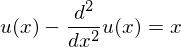

In [3]:
x = Symbol("x")
y = Symbol("y")
u = Function("u")(x)
model_prob = Eq(-Derivative(u,x,2) + u, x)
model_prob

As should be obvious, using `sympy` within a Jupyter Notebook, allows for complex mathematical expressions to be stored as `sympy` objects and displayed in a professionally rendered fashion.

# Weak Form

Our first goal is to obtain the weak form of our model problem.  The weak form is obtained by multiplying the PDE by a test function and integrating the result over the domain.  Typically, integration by parts is applied to reduce terms with second derivatives to first derivatives.  This reduces the smoothness requirements on both the test functions and  the basis functions that ultimately approximate the solution.

The `regen.weak_form()` function takes an `Eq` object as its first argument, the test function as its second argument (so that the user can prevent naming conflicts), and which we name `v`. Note that through inspection, the `regen.weak_form()` function detects the solution variables, in this case `(u(x),)` and the domain variable `x`.

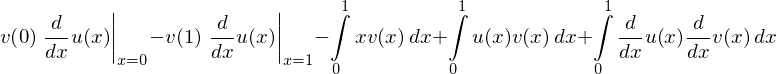

In [4]:
v = Function("v")
weak_form = regen.weak_form(model_prob, v, 0, 1)
weak_form

The weak form is returned in the form of a `sympy.Expr` rather than a `sympy.Eq`, with the implication that the expression sums to zero.  Notice that the term involving the second derivative of $u$ has been replaced by two terms that involve the first derivatives of $u$ and $v$.

# Galerkin Approximation

We now want to substitute an approximation for $u$ into our model problem.  Specifically, we are going to change the model problem to solving for $u_h$ instead of $u$, where

$$
u_h(x) = \sum_{i=0}^{N-1} u_i \phi_i(x)
$$

and the test functions are given by

$$
v(x) \in \{\phi_j(x)\} \, \mbox{ for } j = 0 \ldots N-1
$$

the $\{u_i\}$ are a discrete set of solution coefficients and the ${\phi_i(x)}$ are our basis functions of dimension $N$.  Note that `sympy` supports `IndexedBase` objects and `Function` objects, but not `Function`s that are indexed (at least not that I have figured out yet).  My workaround for this is to define `phi` as a `Function`, with two arguments, `i` (or `j`) and `x`.  This results in the mathematical notation $\phi(i,x)$ rather than the more traditional $\phi_i(x)$.

The `regen.galerkin()` function takes as its first argument an expression or a sequence of expressions, in this case our `weak_form` expression.  For the second argument, it needs to know the test function we used to obtain the weak form, because this function does not get expanded as a series.  The third argument is the basis function for the Galerkin approximation.  It should be constructed without arguments, neither index nor domain variable, because the `regen.galerkin()` function will add these.

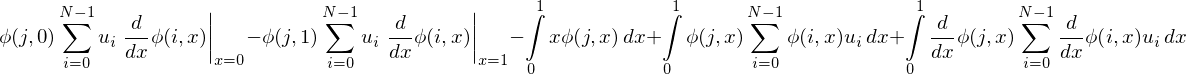

In [5]:
phi = Function('phi')
galerkin = regen.galerkin(weak_form, v, phi)
galerkin

# Assume Cardinal Basis Functions

The expression above is complicated by the first two terms, which come from applying integration by parts to the definite integral that comes from the weak formulation. These two terms are scaled by $\phi_j(x)$ evaluated at the two boundary points, respectively.  As test/basis functions, we get to choose what these functions are.  A common and useful characteristic of test/basis functions is that they are *cardinal* functions.  Cardinal functions have the property that

$$
\phi_j(x_i) =
\left\{
\begin{array}{c}
1 \, \mbox{if} \, i = j    \\
0 \, \mbox{if} \, i \neq j
\end{array}
\right.
$$

A common set of cardinal basis functions is the Lagrange basis functions, which are piecewise polynomials.  There are other sets of cardinal basis functions as well.  If we assume that the basis functions are cardinal functions, and that the boundaries are denoted by $x_0 = 0$ and $x_{N-1} = 1$, and that $j = \{1, \ldots, N-2\}$, then the function evaluations $\phi(j,0)$ and $\phi(j,1)$ in the Galerkin approximation will equal zero, and those terms can be dropped.  We can use the two Dirichlet boundary conditions in the definition of the model problem to account for equations for $j=0$ and $j=N-1$.  We can make this assumption by using the `regen.assume_cardinal()` method:

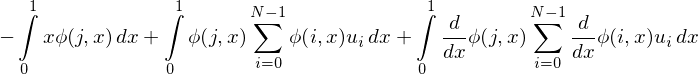

In [6]:
cardinal = regen.assume_cardinal(galerkin, phi)
cardinal

# Quadrature

The $\phi(i,x)$ in the expression above are basis functions that can, in theory, take any form we wish.  In practice, we typically define piecewise polynomial basis functions, which means that the expression above has an analytic solution.  However, it is typically more efficient to "approximate" the above integrals using Gaussian quadrature, followed by choosing the number of quadrature points to represent the integral exactly.

As such, we now wish to convert the integrals to summations by applying Gaussian quadrature, which can be done by the `regen.apply_quadrature()` function:

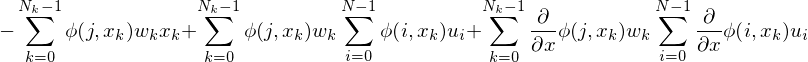

In [7]:
N_k = Symbol('N_k', integer=True)
k   = Idx('k')
w_k = IndexedBase('w')[k]
quadrature = regen.apply_quadrature(cardinal, N_k, w_k)
quadrature

At a glance, you can see that this expression contains summations, but no integrals, unlike the previous expression, which contained both.

# Substituting Functions for Derivatives

At this point in the process, I discovered what I believe is a bug in `sympy`.  The goal at this point is to massage the above expression into one that is more conducive to code generation.  The problem is the derivatives of the basis functions, e.g.

$$
\frac{\partial}{\partial x} \phi(i,x)
$$

evaluated at discrete points $x = x_k$.  Our code will simply store an array with these values, so we want to replace these derivatives with a simple function that represents these derivatives, say

$$
\phi_x(i, x_k)
$$

This should be achievable using the `subs` method of the `sympy.Expr` class:

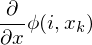

In [8]:
deriv = quadrature.args[1].args[0].args[2].args[0].args[0]
deriv

In [9]:
i, x_k = deriv.args[0].args
i, x_k

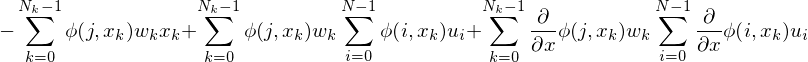

In [10]:
phi_x = Function('phi_x')
quadrature.subs(deriv, phi_x(i, x_k))

The above expression should have $\phi_x(i,x_k)$ substituted for $\partial \phi(i, x_k) / \partial x$, but does not.  I demonstrate this bug, in a simpler context, in __[this notebook](http://localhost:8888/notebooks/SubstitutionBug.ipynb)__, noting that the desired substitution works in a simple expression, but not within a summation.  I submitted this bug as a question to Stack Overflow, and received a response with a reasonable workaround, which I have added to the `regen` module and incorporated into the `regen.substitute_derivatives()` function:

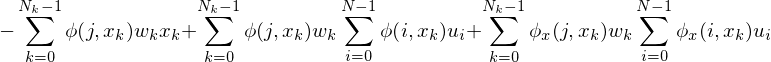

In [11]:
discrete = regen.substitute_derivatives(quadrature)
discrete

At this point in the process, the expression should be in a suitable form for code generation.

# Code Generation

The `sympy` module supports code generation, however, code generation documentation at __[sympy.org](https://docs.sympy.org/latest/modules/codegen.html)__ proved to be inadequate to our purposes.  On the other hand, there are some excellent tutorials online (see this lengthy __[YouTube video](https://www.youtube.com/watch?v=5jzIVp6bTy0)__ for example), so it is possible to learn quite a bit about `sympy` code generation, but in the end, a YouTube video is not a reference along the lines that we need.

This was a very short project to begin with, and a bug in `sympy` was discovered and dealt with.  In the end, there was simply not enough time to explore the code generation issue sufficiently to get it to work.  Having said that, my experience with manipulating `sympy` expressions as a consequence of this project leads me to believe that converting expressions such as the discrete expression above to valid C++ is completely achievable.  It will simply take more time.

To illustrate the difficulty in getting code generation to work, consider that we will absolutely have to handle summations.  Consider the simplest summation one could imagine:

In [12]:
from sympy import Sum, cxxcode
k = Idx('k', range=(0,N_k-1))
w_k = IndexedBase('w')[k]
try:
    cxxcode(Sum(w_k), (k,0,N_k-1))
except ValueError as e:
    print("ValueError:", e)

ValueError: specify dummy variables for w[k]


What is the dummy variable?  Isn't it `k`?  Isn't `k` fully specified with a complete range?  Both in the constructor for `k`, and in the constructor for the `Sum` object?  Obviously the error message is inadequate to fix the problem, and unfortunately, an internet search on `sympy` and `specify dummy variables for`does not yield anything useful.  Here is the full documentation string for function `cxxcode()`:

In [13]:
help(cxxcode)

Help on function cxxcode in module sympy.printing.cxxcode:

cxxcode(expr, assign_to=None, standard='c++11', **settings)
    C++ equivalent of :func:`sympy.ccode`.



This documentation is bare-bones at best.  It is possible that the `settings` keyword arguments might provide some option to get our expression to work, but the docstring does not provide it.

There are other capabilities within the `sympy` module that support code generation, and it might be that these other capabilities are required to generate code for summations and ultimately for our finite element formulation.

# Conclusions

Based on the experience obtained under this NMSBA project, I can draw the following conclusions:

* The Jupyter Notebook should provide an extremely useful interface for users who would want to use the tools ultimately developed in the aftermath of this project to generate Albany `ModelEvaluators`.  It will allow these users to express their PDEs of interest, check them visually with professionally-rendered mathematics, and submit them to the series of manipulations supported by the `regen` module to ultimately produce a finite element approximation to the (set of) PDE(s) and generate code for use in Albany.

* The `sympy` module provides the tools to successfully formulate the weak form of a PDE, apply a Galerkin approximation, simplify in accordance with cardinal basis functions, and utilize Gaussian quadrature to generate an expression that is nearly ready to be used as input to the `sympy` code generation algorithms.  This project uncovered a __[substitution bug](http://localhost:8888/notebooks/Substitution%20Bug.ipynb)__, but a workaround was found to address the problem.

* The model problem employed here is 1D, but most problems of interest will have two, three or four dimensions: $(x,y,z,t)$ for example.  The `sympy` module certainly supports multivariate vector PDEs, via the `CoordSys3D` sub-module:

In [14]:
from sympy.vector import CoordSys3D, Del
R = CoordSys3D("R")
delop = Del()
gradient_field = delop(R.x*R.y*R.z)
gradient_field.doit()

*  This means that the type of problems of interest from science and engineering can be represented.  The functions in the `regen` module that would need modification to support higher dimensions include:

    - `weak_form(eqs, test_func)` would need to be updated to work for higher dimensions.  It currently assumes 1D integrals

    -  `integrate_by_parts(u,v,x)` currently assumes 1D, as implied by the `x` integration argument, meaning the argument list would also change
    
    - `galerkin(expr, test_func, basis)` currently assumes 1D basis functions, which should be expanded to multidimensional tensor-product basis functions
    
    - `assume_cardinal(expr, basis)` assumes 1D basis functions

    - `quadrature(expr)` assumes 1D integrals
    
    - `substitute_derivatives(expr)` assumes 1D derivatives

*  I did not consider here, in any great detail, boundary conditions (BCs), but of course BCs are extremely important for any type of solution (analytic or approximate) for PDEs.  On the other hand, Albany already supports certain types of BCs, and the idea would be to leverage those within the developed application code whenever available.  The `sympy` module supports both definite and indefinite integrals (BCs are expressed through the bounds of definite integrals), so representation is not an issue.  Ultimately I felt that the most efficient use of limited time was to focus on the governing equations.

*  The demonstration here was for a single PDE, but sets of PDEs are supported as well.  Typically, the first argument to functions in the `regen` module is a `sympy.Eq` or `sympy.Expr` object or a sequence of these objects.  These functions typically return a single `sympy.Expr` object or a tuple of them, depending on the input.  Internally, the `regen` module inspects these expressions to obtain things such as the set of differentiated functions, the set of differentiating variables, and and the set of domain variables for the governing PDEs.  These inspections can obviously differ for a single PDE versus a set of PDEs, and processing sets of PDEs was taken as a requirement.

*  An object-oriented interface would be warranted and easy to implement.  Specifically, `regen` could contain a class definition named, say, `PDE`, whose constructor would take a single PDE or a set of PDEs.  It could possibly perform conversion from LaTeX to `sympy` if needed.  It could have optional arguments providing the test functions, basis functions, and quadrature weights.  During the construction phase, the class could obtain the weak form, the Galerkin approximation, the simplification based on cardinal functions, and the discrete representation.  These expressions could be stored as attributes of the object, as could the results of the inspection of the (set of) PDE(s).  The class could also provide a method or methods for code generation, which would allow for supporting multiple output languages.

*  Unfortunately, I was unable to complete the final step of getting code generation to work.  My experience working with and manipulating `sympy` objects, obtained during this project, convinces me that this final step is completely achievable simply with more time.